## Import Libraries

In [34]:
# Basic packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, gc
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; style.use('fivethirtyeight')
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
%matplotlib inline

# Models
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Display settings
pd.options.display.max_rows = 400
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format

random_state = 42
np.random.seed(random_state)

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

## Load and review data

In [3]:
# Reading the data as dataframe and print the first five rows
vehicle_df = pd.read_csv('vehicle-1.csv')
vehicle_df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [4]:
vehicle_df.columns

Index(['compactness', 'circularity', 'distance_circularity', 'radius_ratio',
       'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scatter_ratio',
       'elongatedness', 'pr.axis_rectangularity', 'max.length_rectangularity',
       'scaled_variance', 'scaled_variance.1', 'scaled_radius_of_gyration',
       'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1',
       'skewness_about.2', 'hollows_ratio', 'class'],
      dtype='object')

## Attribute Information
<ul>
    <li>compactness: (average perim)^2/area</li>
    <li>circularity: (average radius)^2/area</li>
    <li>distance_circularity: area/(av.distance from border)^2</li>
    <li>radius_ratio: (max.rad-min.rad)/av.radius</li>
    <li>pr.axis_aspect_ratio: (minor axis)/(major axis)</li>
    <li>max.length_aspect_ratio: (length perp. max length)/(max length)</li>
    <li>scatter_ratio: (inertia about minor axis)/(inertia about major axis)</li>
    <li>elongatedness: area/(shrink width)^2</li>
    <li>pr.axis_rectangularity: area/(pr.axis length*pr.axis width)</li>
    <li>max.length_rectangularity: area/(max.length*length perp. to this)</li>
    <li>scaled_variance: (2nd order moment about minor axis)/area along major axis</li>
    <li>scaled_variance.1: (2nd order moment about major axis)/area along minor axis</li>
    <li>scaled_radius_of_gyration: (mavar+mivar)/area</li>
    <li>scaled_radius_of_gyration.1</li>
    <li>skewness_about: (3rd order moment about major axis)/sigma_min^3 major axis</li>
    <li>skewness_about.1: (3rd order moment about minor axis)/sigma_maj^3 minor axis</li>
    <li>skewness_about.2</li>
    <li>hollows_ratio: (area of hollows)/(area of bounding polygon)</li>
    <li>class: van, car, bus</li>
</ul>

## Get info of the dataframe columns

In [5]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

## Dataset shape 

In [6]:
vehicle_df.shape

(846, 19)

In [7]:
# Checking missing values in dataframe
vehicle_df.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

## Exploratory Data Analysis

<ul>
    <li>Get descriptive statistics including five point summary</li>
    <li>Comment on the types of variables in dataset and descriptive statistics observation</li>
    <li>Check unique values in class columns</li>
    <li>Check distribution of class column</li>
    <li>Check missing values in the dataframe and impute those missing values</li>
    <li>Univariate and Bivariate visualization: Looking at one feature at a time to understand how are the values are distributed, checking outliers and relation of the columns with class</li>
    <li>Handle outliers using SimpleImputer</li>
    <li>Multivariate visualization including correlation and scatterplot matrix. In the process identify the features to be taken further for the study</li>
    <li>Handle imbalance in no of observations in target(class) varable.</li>
</ul>    

### Five point summary of numerical attributes and check unique values in 'object' columns

In [8]:
# Five point summary
vehicle_df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
compactness,846,NaN,NaN,NaN,93.6785,8.23447,73,87,93,100,119
circularity,841,NaN,NaN,NaN,44.8288,6.15217,33,40,44,49,59
distance_circularity,842,NaN,NaN,NaN,82.1105,15.7783,40,70,80,98,112
radius_ratio,840,NaN,NaN,NaN,168.888,33.5202,104,141,167,195,333
pr.axis_aspect_ratio,844,NaN,NaN,NaN,61.6789,7.89146,47,57,61,65,138
max.length_aspect_ratio,846,NaN,NaN,NaN,8.56738,4.60122,2,7,8,10,55
scatter_ratio,845,NaN,NaN,NaN,168.902,33.2148,112,147,157,198,265
elongatedness,845,NaN,NaN,NaN,40.9337,7.81619,26,33,43,46,61
pr.axis_rectangularity,843,NaN,NaN,NaN,20.5824,2.59293,17,19,20,23,29
max.length_rectangularity,846,NaN,NaN,NaN,147.999,14.5157,118,137,146,159,188


## Checking the distribution of class variable 

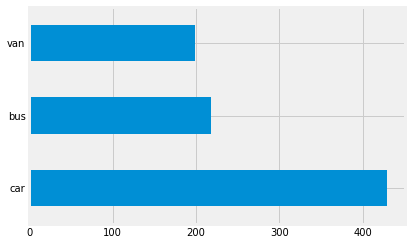

In [9]:
vehicle_df["class"].value_counts().plot(kind='barh')

In [10]:
display(vehicle_df['class'].value_counts(), vehicle_df['class'].value_counts(normalize = True)*100)

car    429
bus    218
van    199
Name: class, dtype: int64

car    50.709220
bus    25.768322
van    23.522459
Name: class, dtype: float64

In [11]:
replace_struc = {'car': 3, 'bus': 2, 'van': 1}
vehicle_df['class'] = vehicle_df['class'].map(replace_struc)
del replace_struc

#### Observation: Count of observations with class car is much more(imbalanced) with respect to other classes. car represents about 50.7% of the total values in class variable, bus about 25.8% and van about 23.5%.

In [12]:
# Check missing values in the dataframe
vehicle_df.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

### Using SimpleImputer to handle missing values 

In [13]:
null_columns = vehicle_df.columns[vehicle_df.isnull().any()]; columns = list(vehicle_df.columns)

print('Descriptive Stats before imputation for columns with missing values: \n', '--'*35)
display(vehicle_df[null_columns].describe().T)

# Using SimpleImputer to fill missing values by median
impute = SimpleImputer(missing_values = np.nan, strategy = 'median', verbose = 1)
vehicle = pd.DataFrame(impute.fit_transform(vehicle_df), columns = columns)

print('Descriptive Stats after imputation: \n', '--'*35)
display(vehicle[null_columns].describe().T)

del null_columns

Descriptive Stats before imputation for columns with missing values: 
 ----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
circularity,841.0,44.828775,6.152172,33.0,40.0,44.0,49.0,59.0
distance_circularity,842.0,82.110451,15.778292,40.0,70.0,80.0,98.0,112.0
radius_ratio,840.0,168.888095,33.520198,104.0,141.0,167.0,195.0,333.0
pr.axis_aspect_ratio,844.0,61.678910,7.891463,47.0,57.0,61.0,65.0,138.0
scatter_ratio,845.0,168.901775,33.214848,112.0,147.0,157.0,198.0,265.0
elongatedness,845.0,40.933728,7.816186,26.0,33.0,43.0,46.0,61.0
pr.axis_rectangularity,843.0,20.582444,2.592933,17.0,19.0,20.0,23.0,29.0
scaled_variance,843.0,188.631079,31.411004,130.0,167.0,179.0,217.0,320.0
scaled_variance.1,844.0,439.494076,176.666903,184.0,318.0,363.5,587.0,1018.0
scaled_radius_of_gyration,844.0,174.709716,32.584808,109.0,149.0,173.5,198.0,268.0


Descriptive Stats after imputation: 
 ----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
circularity,846.0,44.823877,6.134272,33.0,40.00,44.0,49.00,59.0
distance_circularity,846.0,82.100473,15.741569,40.0,70.00,80.0,98.00,112.0
radius_ratio,846.0,168.874704,33.401356,104.0,141.00,167.0,195.00,333.0
pr.axis_aspect_ratio,846.0,61.677305,7.882188,47.0,57.00,61.0,65.00,138.0
scatter_ratio,846.0,168.887707,33.197710,112.0,147.00,157.0,198.00,265.0
elongatedness,846.0,40.936170,7.811882,26.0,33.00,43.0,46.00,61.0
pr.axis_rectangularity,846.0,20.580378,2.588558,17.0,19.00,20.0,23.00,29.0
scaled_variance,846.0,188.596927,31.360427,130.0,167.00,179.0,217.00,320.0
scaled_variance.1,846.0,439.314421,176.496341,184.0,318.25,363.5,586.75,1018.0
scaled_radius_of_gyration,846.0,174.706856,32.546277,109.0,149.00,173.5,198.00,268.0


#### Observation - After imputation
No significant change in median in dataset, gradual right shift of mean can be observed.

### Function to plot boxplot and distplot with/without outliers

In [14]:
# Functions that will help us with EDA plot
def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm).set_title(f'{col} with outliers')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm).set_title(f'{col} without outliers')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()

### Function to plot distribution of target variable(class)

In [15]:
# function for ploting distribution of variables with target
def target_plot(df, col1, col2, col3, target = 'class'):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    f.suptitle(f'Distribution for Car, Bus, Van for {col1.capitalize()}, {col2.capitalize()}, {col3.capitalize()}', 
               fontsize = 14)
    # Distribution for col1 considering outliers
    sns.distplot(df[(df[target] == 3)][col1], color = 'c', ax = ax1, hist = False, 
                 label = 'Car').set_title(f'{col1.capitalize()}', fontsize=14,
            fontstyle='italic', fontweight='bold')
    sns.distplot(df[(df[target] == 2)][col1], color = 'b', ax = ax1, hist = False, 
                 label = 'Bus').set_title(f'{col1.capitalize()}', fontsize=14,
            fontstyle='italic', fontweight='bold')
    sns.distplot(df[(df[target] == 1)][col1], color = 'm', ax = ax1, hist = False, 
                 label = 'Van').set_title(f'{col1.capitalize()}', fontsize=14,
            fontstyle='italic', fontweight='bold')

    # Distribution for col2 considering outliers
    sns.distplot(df[(df[target] == 3)][col2], color = 'c', ax = ax2, hist = False, 
                 label = 'Car').set_title(f'{col2.capitalize()}', fontsize=14,
            fontstyle='italic', fontweight='bold')
    sns.distplot(df[(df[target] == 2)][col2], color = 'b', ax = ax2, hist = False, 
                 label = 'Bus').set_title(f'{col2.capitalize()}', fontsize=14,
            fontstyle='italic', fontweight='bold')
    sns.distplot(df[(df[target] == 1)][col2], color = 'm', ax = ax2, hist = False, 
                 label = 'Van').set_title(f'{col2.capitalize()}', fontsize=14,
            fontstyle='italic', fontweight='bold')

    # Distribution for col3 considering outliers
    sns.distplot(df[(df[target] == 3)][col3], color = 'c', ax = ax3, hist = False, 
                 label = 'Car').set_title(f'{col3.capitalize()}', fontsize=14,
            fontstyle='italic', fontweight='bold')
    sns.distplot(df[(df[target] == 2)][col3], color = 'b', ax = ax3, hist = False, 
                 label = 'Bus').set_title(f'{col3.capitalize()}', fontsize=14,
            fontstyle='italic', fontweight='bold')
    sns.distplot(df[(df[target] == 1)][col3], color = 'm', ax = ax3, hist = False, 
                 label = 'Van').set_title(f'{col3.capitalize()}', fontsize=14,
            fontstyle='italic', fontweight='bold')
    return plt.show()

### Function to plot correlations and extract variables above threshold value

In [16]:
# Correlation matrix for all variables
def correlation_matrix(df, threshold = 0.8):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (15, 7.2))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, square = True, linewidths = .5, cbar_kws = {"shrink": .5})#, annot = True)
    ax.set_title('Correlation Matrix of Data')

    # Filter for correlation value greater than threshold
    sort = corr.abs().unstack()
    sort = sort.sort_values(kind = "quicksort", ascending = False)
    display(sort[(sort > threshold) & (sort < 1)])

### Function to plot PCA resultants

In [17]:
# Helper function for PCA plots
def pca_plots(df, col1, col2, xlabel, ylabel, ax):
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    ax.set_title(f'{xlabel} vs {ylabel}', fontsize = 14)
    targets = [3, 2, 1]; colors = ['r', 'g', 'b']
    for target, color in zip(targets, colors):
        indicesToKeep = df['class'] == target
        ax.scatter(df.loc[indicesToKeep, col1], df.loc[indicesToKeep, col2], c = color, s = 50)
    ax.legend(targets)

### Function to plot learning curve

In [18]:
# Helper function to plot learning curve
def plot_learning_curve(estimator, X, y,  ax, ylim = None, cv = None, n_jobs = 1,
                        train_sizes = np.linspace(.1, 1.0, 5), name = 'Naive Bayes \n Principal Compoents Learning Curve'):    
    if ylim is not None:
        plt.ylim(*ylim)
        
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, 
                                                            train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                     alpha = 0.1, color = '#ff9124')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                     alpha = 0.1, color = '#2492ff')

    ax.plot(train_sizes, train_scores_mean, 'o-', color = '#ff9124', label = 'Training score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color ='#2492ff', label = 'Cross-validation score')
    ax.set_title(name, fontsize = 14)
    ax.set_xlabel('Training size')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc = 'best')

### Univariate and Bivariate Visualization

In this section, we will plot boxplot and distplot with/without outliers of all the independent variables. 
Also, we will learn about their relationships with target variable.

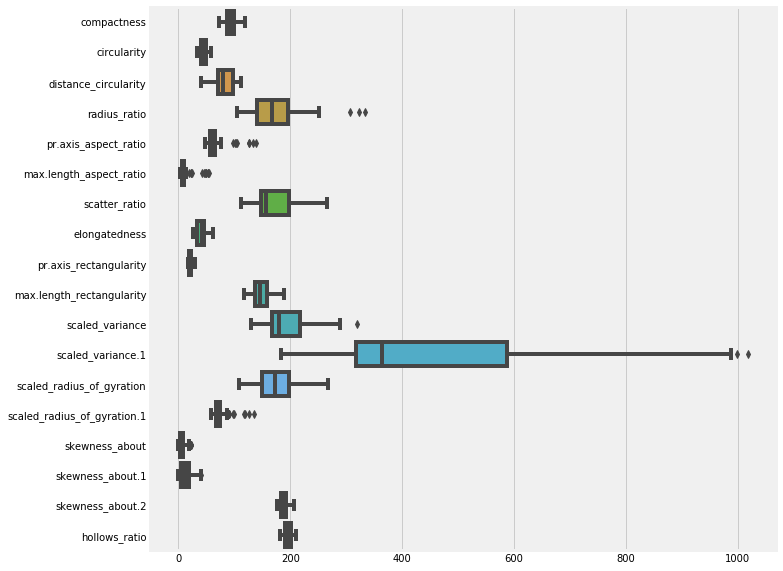

In [19]:
# A quick check to find columns that contain outliers
fig = plt.figure(figsize = (10, 10))
ax = sns.boxplot(data = vehicle.iloc[:, 0:18], orient = 'h')

Radius_ratio column --------------------------------------------------------------------------------
no of records with outliers values: 3


,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
37,90.0,48.0,86.0,306.0,126.0,49.0,153.0,44.0,19.0,156.0,272.0,346.0,200.0,118.0,0.0,15.0,185.0,194.0,1.0
135,89.0,47.0,83.0,322.0,133.0,48.0,158.0,43.0,20.0,163.0,229.0,364.0,176.0,97.0,0.0,14.0,184.0,194.0,1.0
388,94.0,47.0,85.0,333.0,138.0,49.0,155.0,43.0,19.0,155.0,320.0,354.0,187.0,135.0,12.0,9.0,188.0,196.0,1.0


EDA for Radius_ratio column --------------------------------------------------------------------------------


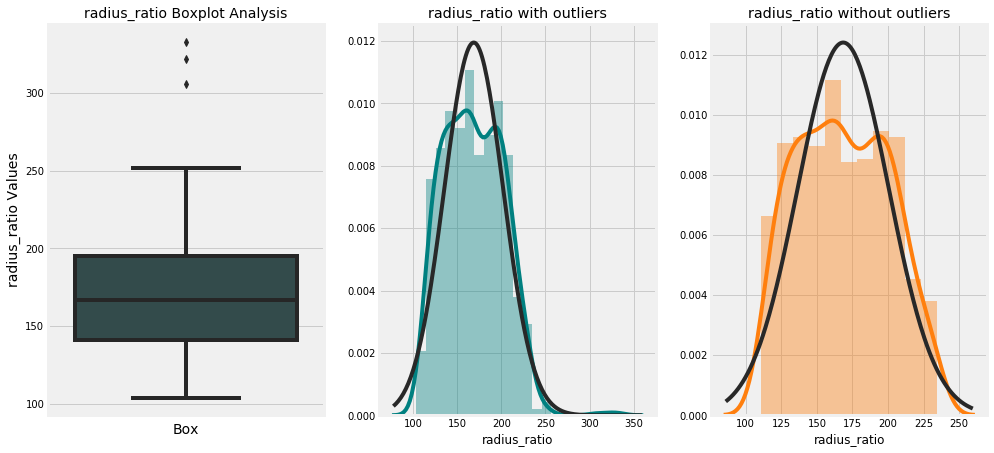

Pr.axis_aspect_ratio column --------------------------------------------------------------------------------
no of records with outliers values: 8


,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
4,85.0,44.0,70.0,205.0,103.0,52.0,149.0,45.0,19.0,144.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183.0,2.0
37,90.0,48.0,86.0,306.0,126.0,49.0,153.0,44.0,19.0,156.0,272.0,346.0,200.0,118.0,0.0,15.0,185.0,194.0,1.0
100,82.0,45.0,66.0,252.0,126.0,52.0,148.0,45.0,19.0,144.0,237.0,326.0,185.0,119.0,1.0,1.0,181.0,185.0,2.0
135,89.0,47.0,83.0,322.0,133.0,48.0,158.0,43.0,20.0,163.0,229.0,364.0,176.0,97.0,0.0,14.0,184.0,194.0,1.0
291,89.0,45.0,81.0,246.0,102.0,43.0,155.0,44.0,20.0,160.0,200.0,347.0,177.0,90.0,9.0,17.0,183.0,192.0,1.0


EDA for Pr.axis_aspect_ratio column --------------------------------------------------------------------------------


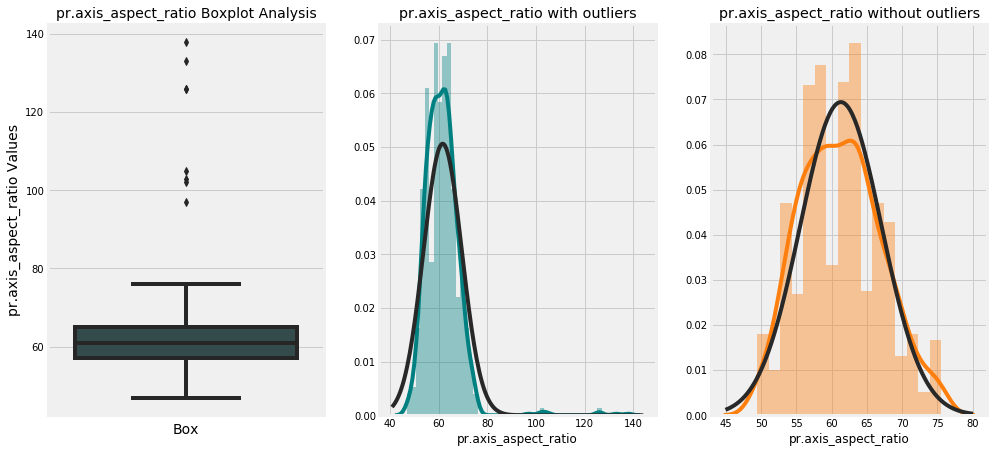

Max.length_aspect_ratio column --------------------------------------------------------------------------------
no of records with outliers values: 13


,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
4,85.0,44.0,70.0,205.0,103.0,52.0,149.0,45.0,19.0,144.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183.0,2.0
37,90.0,48.0,86.0,306.0,126.0,49.0,153.0,44.0,19.0,156.0,272.0,346.0,200.0,118.0,0.0,15.0,185.0,194.0,1.0
100,82.0,45.0,66.0,252.0,126.0,52.0,148.0,45.0,19.0,144.0,237.0,326.0,185.0,119.0,1.0,1.0,181.0,185.0,2.0
127,85.0,41.0,66.0,155.0,65.0,22.0,149.0,45.0,19.0,139.0,173.0,330.0,155.0,75.0,6.0,16.0,184.0,191.0,2.0
135,89.0,47.0,83.0,322.0,133.0,48.0,158.0,43.0,20.0,163.0,229.0,364.0,176.0,97.0,0.0,14.0,184.0,194.0,1.0


EDA for Max.length_aspect_ratio column --------------------------------------------------------------------------------


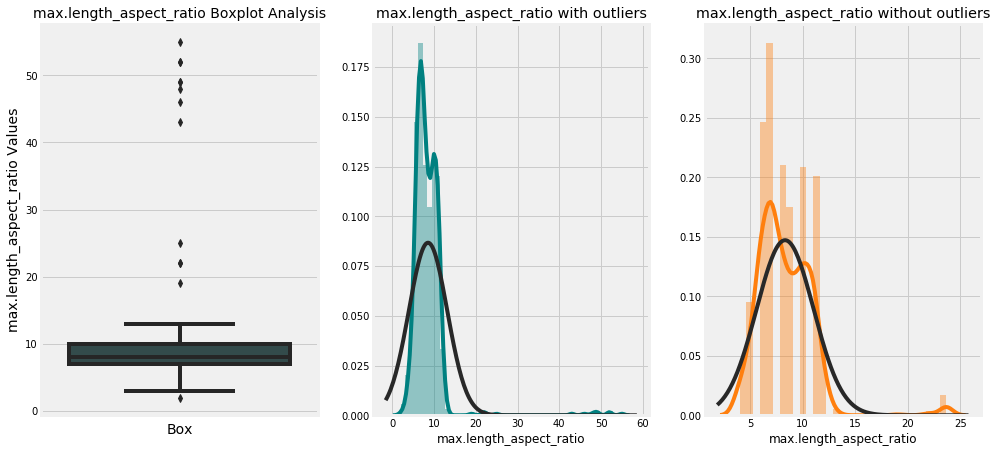

Scaled_variance column --------------------------------------------------------------------------------
no of records with outliers values: 1


,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
388,94.0,47.0,85.0,333.0,138.0,49.0,155.0,43.0,19.0,155.0,320.0,354.0,187.0,135.0,12.0,9.0,188.0,196.0,1.0


EDA for Scaled_variance column --------------------------------------------------------------------------------


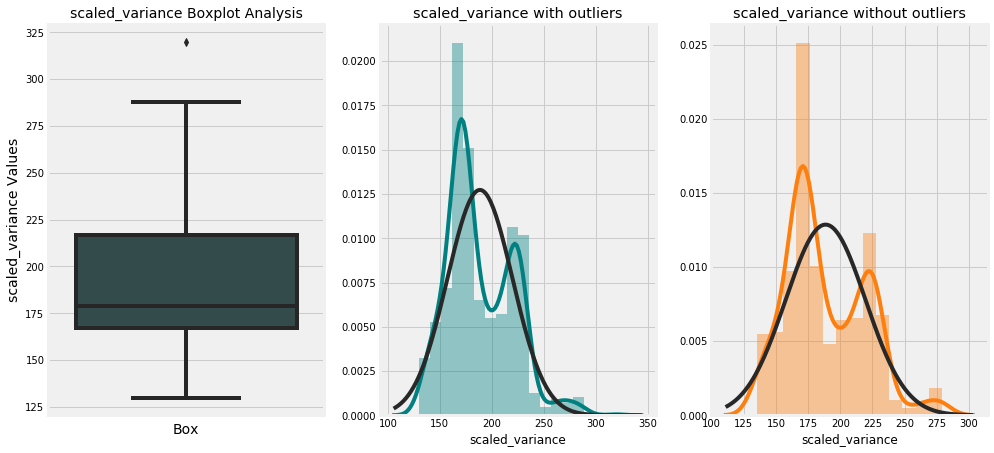

Scaled_variance.1 column --------------------------------------------------------------------------------
no of records with outliers values: 2


,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
85,110.0,58.0,106.0,180.0,51.0,6.0,261.0,26.0,28.0,171.0,278.0,998.0,257.0,83.0,9.0,13.0,181.0,182.0,2.0
835,111.0,58.0,105.0,183.0,51.0,6.0,265.0,26.0,29.0,174.0,285.0,1018.0,255.0,85.0,4.0,8.0,181.0,183.0,2.0


EDA for Scaled_variance.1 column --------------------------------------------------------------------------------


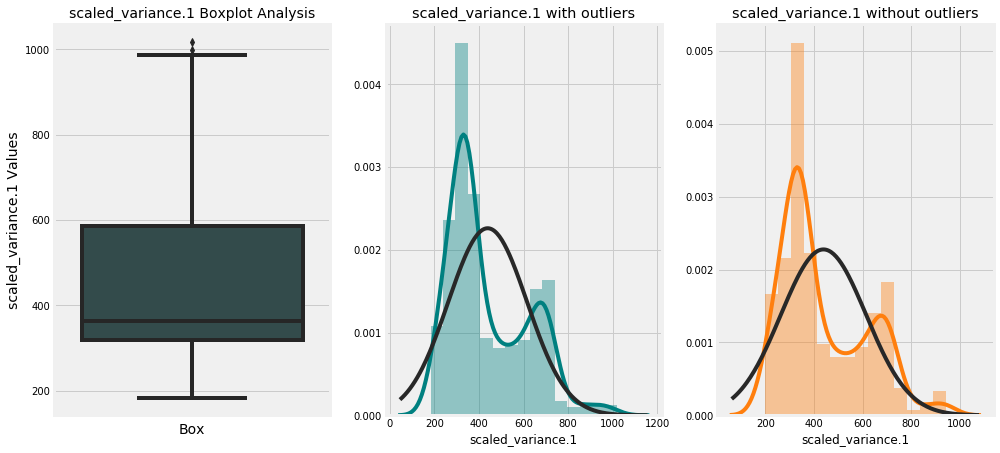

Scaled_radius_of_gyration.1 column --------------------------------------------------------------------------------
no of records with outliers values: 15


,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
4,85.0,44.0,70.0,205.0,103.0,52.0,149.0,45.0,19.0,144.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183.0,2.0
37,90.0,48.0,86.0,306.0,126.0,49.0,153.0,44.0,19.0,156.0,272.0,346.0,200.0,118.0,0.0,15.0,185.0,194.0,1.0
47,85.0,42.0,66.0,122.0,54.0,6.0,148.0,46.0,19.0,141.0,172.0,317.0,174.0,88.0,6.0,14.0,180.0,182.0,2.0
79,89.0,44.0,68.0,113.0,50.0,7.0,150.0,45.0,19.0,147.0,171.0,328.0,189.0,88.0,6.0,5.0,179.0,182.0,2.0
100,82.0,45.0,66.0,252.0,126.0,52.0,148.0,45.0,19.0,144.0,237.0,326.0,185.0,119.0,1.0,1.0,181.0,185.0,2.0


EDA for Scaled_radius_of_gyration.1 column --------------------------------------------------------------------------------


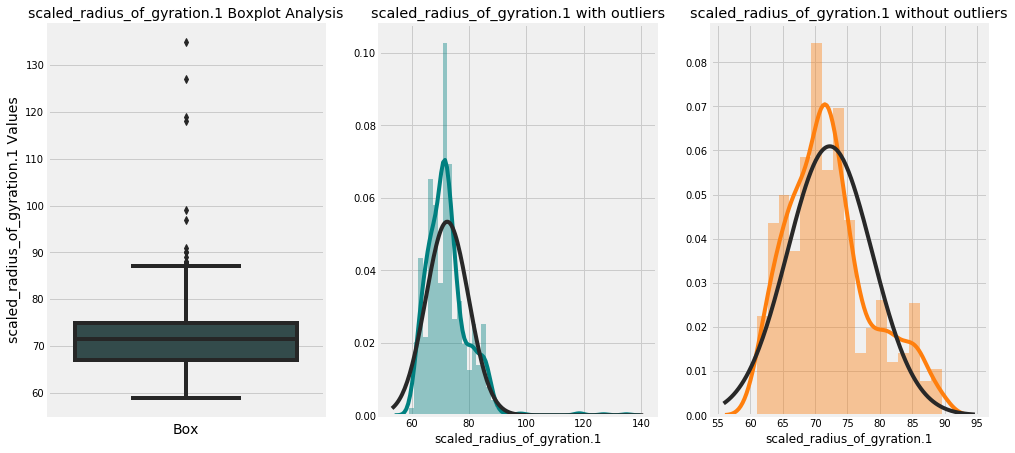

Skewness_about column --------------------------------------------------------------------------------
no of records with outliers values: 12


,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
44,119.0,54.0,106.0,220.0,65.0,12.0,213.0,31.0,24.0,167.0,223.0,675.0,232.0,66.0,20.0,1.0,192.0,202.0,3.0
113,88.0,35.0,50.0,121.0,58.0,5.0,114.0,59.0,17.0,122.0,132.0,192.0,138.0,74.0,21.0,4.0,182.0,187.0,3.0
123,90.0,36.0,57.0,130.0,57.0,6.0,121.0,56.0,17.0,127.0,137.0,216.0,132.0,68.0,22.0,23.0,190.0,195.0,3.0
190,97.0,48.0,94.0,198.0,63.0,9.0,181.0,36.0,21.0,155.0,200.0,494.0,189.0,64.0,20.0,11.0,199.0,203.0,3.0
346,117.0,52.0,110.0,228.0,65.0,12.0,212.0,31.0,24.0,163.0,228.0,668.0,220.0,66.0,21.0,25.0,194.0,205.0,3.0


EDA for Skewness_about column --------------------------------------------------------------------------------


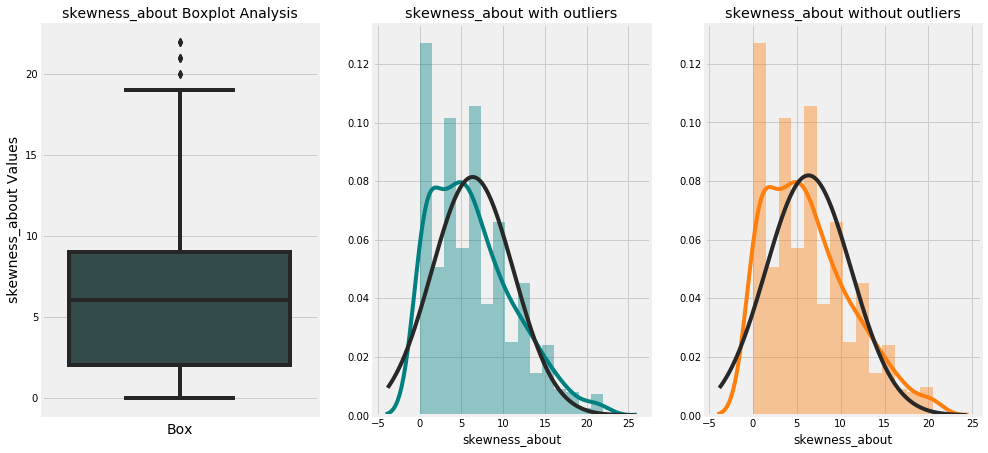

Skewness_about.1 column --------------------------------------------------------------------------------
no of records with outliers values: 1


,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
132,97.0,42.0,101.0,186.0,59.0,9.0,186.0,36.0,22.0,138.0,208.0,511.0,168.0,67.0,7.0,41.0,194.0,206.0,3.0


EDA for Skewness_about.1 column --------------------------------------------------------------------------------


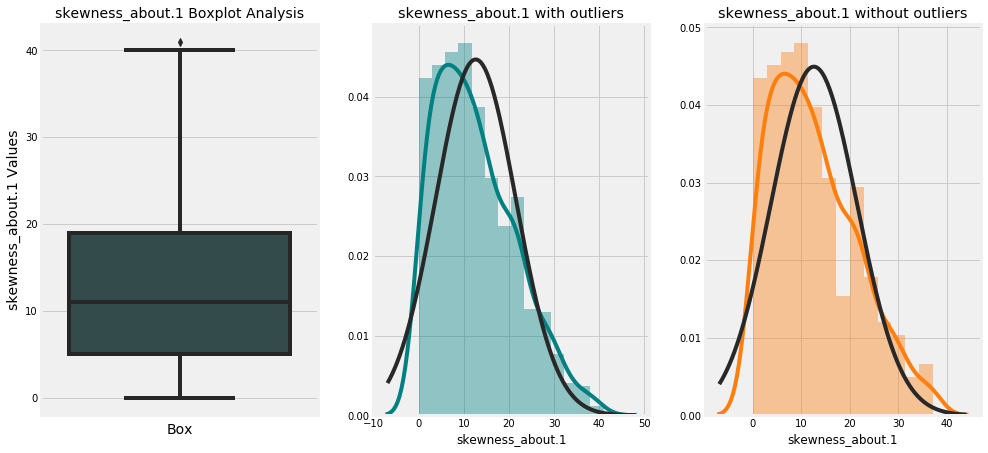

In [20]:
# Outlier, distribution for columns with outliers
boxplotcolumns = ['radius_ratio', 'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scaled_variance', 'scaled_variance.1',
                  'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1']
for cols in boxplotcolumns:
    Q3 = vehicle[cols].quantile(0.75)
    Q1 = vehicle[cols].quantile(0.25)
    IQR = Q3 - Q1

    print(f'{cols.capitalize()} column', '--'*40)
    count = len(vehicle.loc[(vehicle[cols] < (Q1 - 1.5 * IQR)) | (vehicle[cols] > (Q3 + 1.5 * IQR))])
    print(f'no of records with outliers values: {count}')
    
    display(vehicle.loc[(vehicle[cols] < (Q1 - 1.5 * IQR)) | (vehicle[cols] > (Q3 + 1.5 * IQR))].head())
    print(f'EDA for {cols.capitalize()} column', '--'*40)
    odp_plots(vehicle, cols)

del cols, IQR, boxplotcolumns

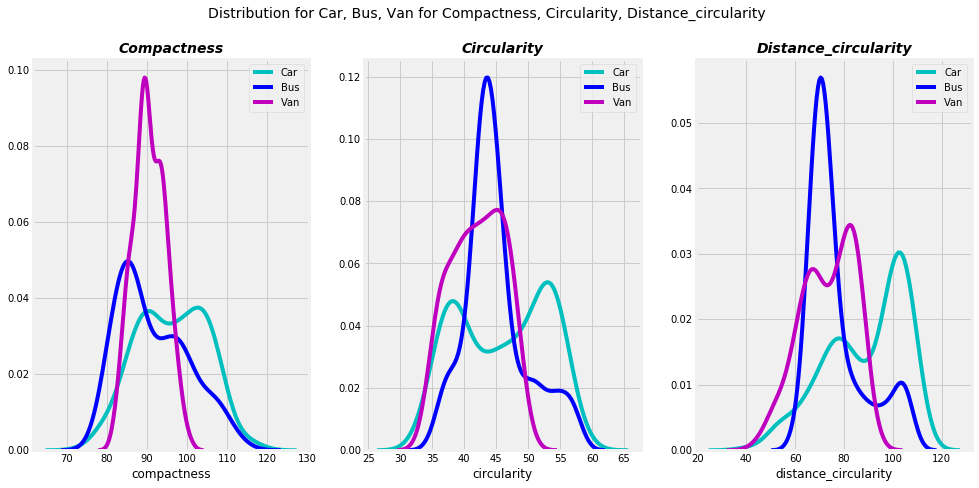

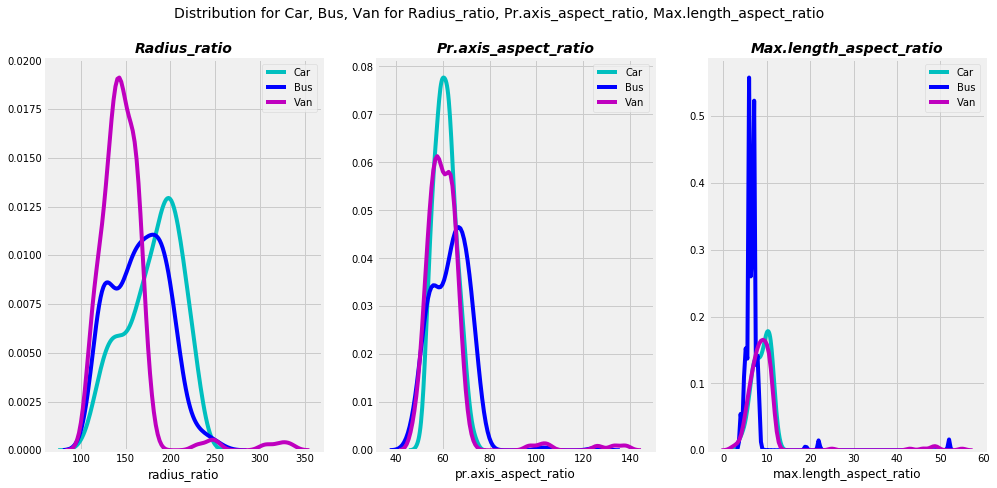

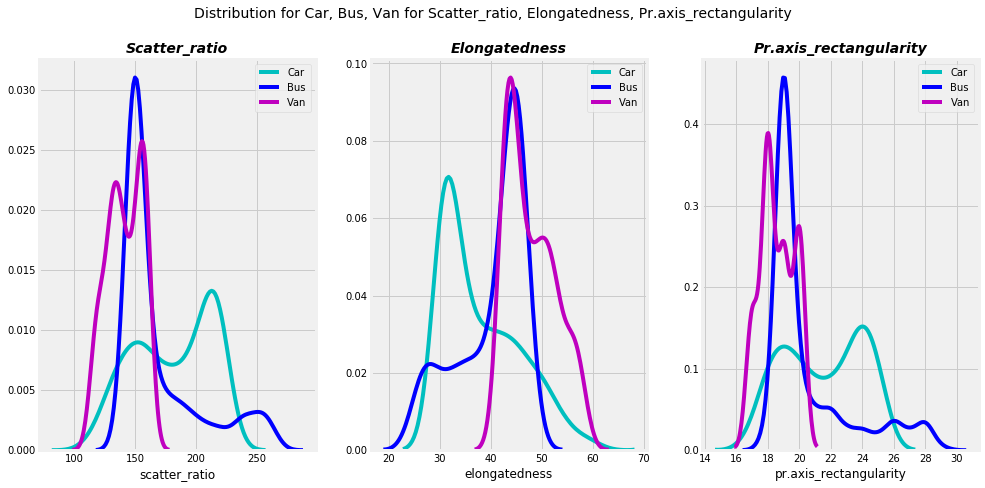

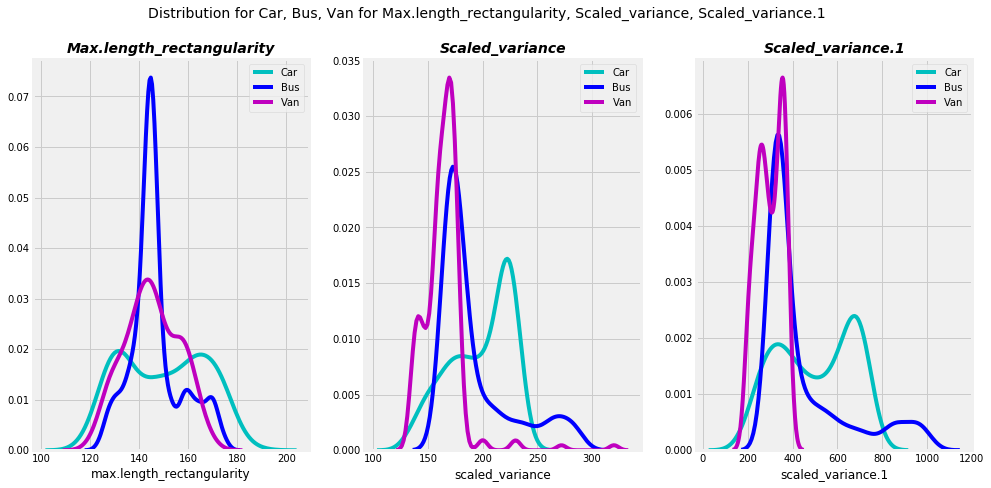

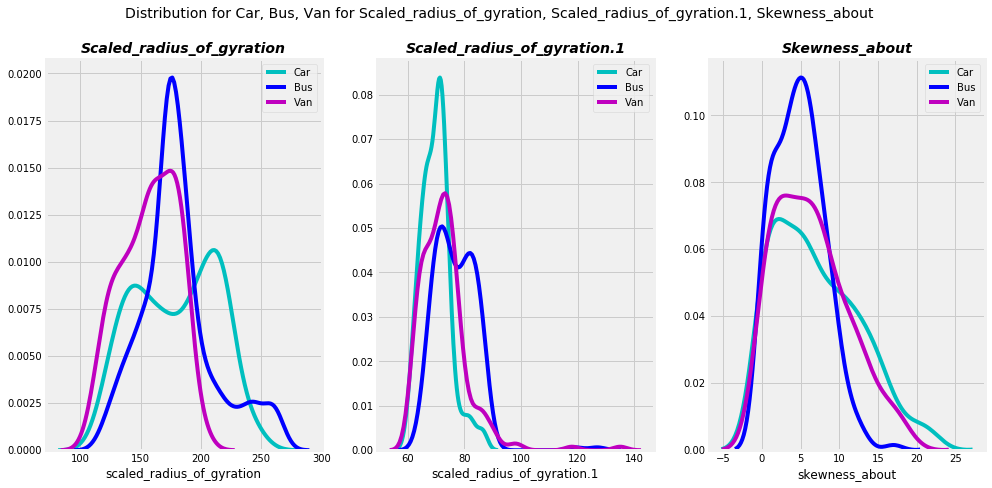

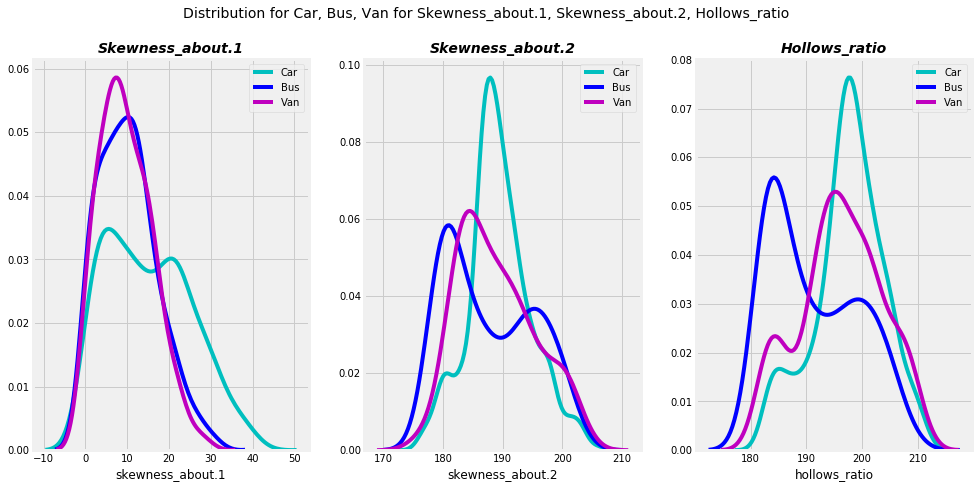

In [21]:
# Distribution of col by target variable
target_plot(vehicle, 'compactness', 'circularity', 'distance_circularity')
target_plot(vehicle, 'radius_ratio', 'pr.axis_aspect_ratio', 'max.length_aspect_ratio')
target_plot(vehicle, 'scatter_ratio', 'elongatedness', 'pr.axis_rectangularity')
target_plot(vehicle, 'max.length_rectangularity', 'scaled_variance', 'scaled_variance.1')
target_plot(vehicle, 'scaled_radius_of_gyration', 'scaled_radius_of_gyration.1', 'skewness_about')
target_plot(vehicle, 'skewness_about.1', 'skewness_about.2', 'hollows_ratio')

#### Observation 6 - Comments after checking outliers and distribution 

<ul>
   <li> Used box plot for the features of the vehicle dataframe. Found that radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scaled_variance, scaled_variance.1, scaled_radius_of_gyration.1, skewness_about, skewness_about.1 columns has outliers.</li>
   <li>Used quantile method to check outliers in these column. It appears that scaled_radius_of_gyration.1 has maximum outliers around 15 of them, which represents about 1.77% of number of rows.</li>
   <li>It appears that removing outliers below 25% percentile and above 75% percentile will bring most of the columns to almost normal distribution. That would mean losing around 1.77% of the data.</li>
</ul>
Let's not to that, rather replace these outliers with null values and then replace those nulls with median values to avoid losing data.

### Handling outliers using SimpleImputer 

In [23]:
# Removing outliers with upper and lower percentile values being 75 and 25, respectively
vehicle_im = vehicle.copy(deep = True)
outliers_cols = ['radius_ratio', 'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scaled_variance', 'scaled_variance.1',
           'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1']

for col in outliers_cols:
    Q3 = vehicle_im[col].quantile(0.75)
    Q1 = vehicle_im[col].quantile(0.25)
    IQR = Q3 - Q1
    upper_lim = Q3 + (1.5 * IQR)
    lower_lim = Q1 - (1.5 * IQR)
    vehicle_im.loc[(vehicle_im[col] < lower_lim) | (vehicle_im[col] > upper_lim), col] = np.nan

print('Column for which outliers where removed with upper and lower percentile values: \n', outliers_cols)

Column for which outliers where removed with upper and lower percentile values: 
 ['radius_ratio', 'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scaled_variance', 'scaled_variance.1', 'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1']


In [24]:
vehicle_im.isnull().sum()

compactness                     0
circularity                     0
distance_circularity            0
radius_ratio                    3
pr.axis_aspect_ratio            8
max.length_aspect_ratio        13
scatter_ratio                   0
elongatedness                   0
pr.axis_rectangularity          0
max.length_rectangularity       0
scaled_variance                 1
scaled_variance.1               2
scaled_radius_of_gyration       0
scaled_radius_of_gyration.1    15
skewness_about                 12
skewness_about.1                1
skewness_about.2                0
hollows_ratio                   0
class                           0
dtype: int64

In [25]:
# Using SimpleImputer to fill missing values by median
print('Descriptive Stats before handling outliers: \n', '--'*30)
display(vehicle[outliers_cols].describe().T)

columns = list(vehicle_im.columns)
impute = SimpleImputer(missing_values = np.nan, strategy = 'median', verbose = 1)
vehicle_im = pd.DataFrame(impute.fit_transform(vehicle_im), columns = columns)

print('Descriptive Stats after handling outliers: \n', '--'*30)
display(vehicle_im[outliers_cols].describe().T)
del outliers_cols, vehicle

Descriptive Stats before handling outliers: 
 ------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
radius_ratio,846.0,168.874704,33.401356,104.0,141.00,167.0,195.00,333.0
pr.axis_aspect_ratio,846.0,61.677305,7.882188,47.0,57.00,61.0,65.00,138.0
max.length_aspect_ratio,846.0,8.567376,4.601217,2.0,7.00,8.0,10.00,55.0
scaled_variance,846.0,188.596927,31.360427,130.0,167.00,179.0,217.00,320.0
scaled_variance.1,846.0,439.314421,176.496341,184.0,318.25,363.5,586.75,1018.0
scaled_radius_of_gyration.1,846.0,72.443262,7.468734,59.0,67.00,71.5,75.00,135.0
skewness_about,846.0,6.361702,4.903244,0.0,2.00,6.0,9.00,22.0
skewness_about.1,846.0,12.600473,8.930962,0.0,5.00,11.0,19.00,41.0


Descriptive Stats after handling outliers: 
 ------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
radius_ratio,846.0,168.330969,32.147908,104.0,141.00,167.00,194.75,252.0
pr.axis_aspect_ratio,846.0,61.154846,5.613458,47.0,57.00,61.00,65.00,76.0
max.length_aspect_ratio,846.0,8.118203,2.064114,3.0,7.00,8.00,10.00,13.0
scaled_variance,846.0,188.430260,31.034232,130.0,167.00,179.00,216.75,288.0
scaled_variance.1,846.0,437.790189,174.346317,184.0,318.25,363.25,586.00,987.0
scaled_radius_of_gyration.1,846.0,71.934988,6.159846,59.0,67.00,71.00,75.00,87.0
skewness_about,846.0,6.133570,4.574939,0.0,2.00,5.00,9.00,19.0
skewness_about.1,846.0,12.565012,8.877465,0.0,5.00,11.00,19.00,40.0


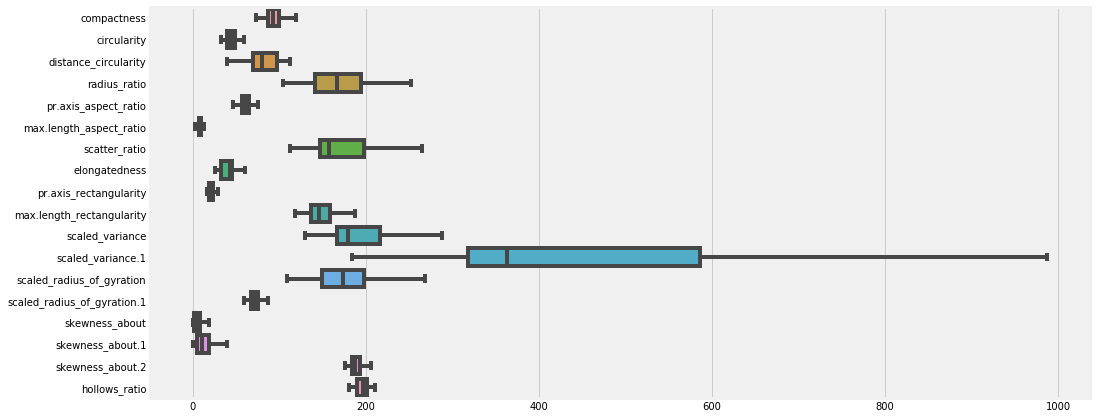

In [26]:
# A quick check to find columns that contain outliers
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(data = vehicle_im.iloc[:, 0:18], orient = 'h')

#### Observation - Comments after checking outliers and distribution 

<ul>
    <li>Instead of removing the outliers, which might have resulted in loss of data, we first replaced the outliers (using IQR method) with nulls and then used SimpleImputer to replace those nulls with median values.</li>
    <li>Again, there's least effect on means and no effect on (ofcourse) median.</li>
</ul>    

### Multivariate Visualization 

Checking relationship between two or more variables. Includes correlation and scatterplot matrix, checking relation between two variables and target variable.

scatter_ratio                pr.axis_rectangularity         0.989751
pr.axis_rectangularity       scatter_ratio                  0.989751
scaled_variance.1            scatter_ratio                  0.980435
scatter_ratio                scaled_variance.1              0.980435
pr.axis_rectangularity       scaled_variance.1              0.973594
scaled_variance.1            pr.axis_rectangularity         0.973594
scatter_ratio                elongatedness                  0.971601
elongatedness                scatter_ratio                  0.971601
max.length_rectangularity    circularity                    0.961318
circularity                  max.length_rectangularity      0.961318
scaled_variance              scatter_ratio                  0.960883
scatter_ratio                scaled_variance                0.960883
elongatedness                pr.axis_rectangularity         0.948996
pr.axis_rectangularity       elongatedness                  0.948996
elongatedness                scale

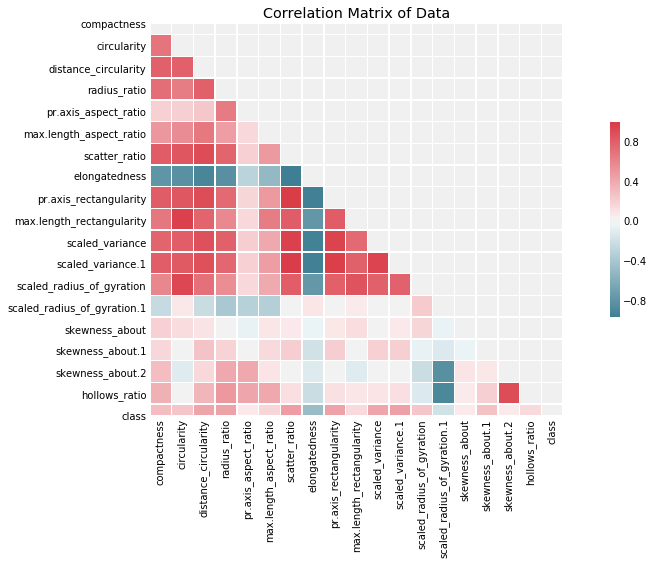

In [27]:
# Correlation matrix for all variables
correlation_matrix(vehicle_im, threshold = 0.8)

In [28]:
# Absolute correlation of independent variables with the target variable
absCorrwithDep = []
allVars = vehicle_im.drop('class', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(vehicle_im['class'].corr(vehicle_im[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

,Variable,Correlation
7,elongatedness,0.483027
6,scatter_ratio,0.463566
11,scaled_variance.1,0.4516
8,pr.axis_rectangularity,0.444586
3,radius_ratio,0.444101
2,distance_circularity,0.428523
10,scaled_variance,0.420329
0,compactness,0.297774
15,skewness_about.1,0.269542
1,circularity,0.251281


#### Observation  - Correlation matrix 
<ul>

   <li> scatter_ratio and pr.axis_rectangularity; scaled_variance.1 and scatter_ratio; pr.axis_rectangularity and scaled_variance.1; pr.axis_rectangularity and scaled_variance.1; elongatedness and scatter_ratio; circularity and max.length_rectangularity; scaled_variance and scatter_ratio; elongatedness and pr.axis_rectangularity; elongatedness and scaled_variance.1; elongatedness and scaled_variance; pr.axis_rectangularity, scaled_variance and scaled_variance.1; distance_circularity and elongatedness; circularity and scaled_radius_of_gyration; distance_circularity and elongatedness; scatter_ratio and distance_circularity are correlated with each other with a correlation coeff greater than 0.9.</li>
    <li>elongatedness, scatter_ratio, scaled_variance.1, pr.axis_rectangularity and radius_ratio are some columns which have relatively strong correlation with the class variable.</li>
    <li>Though multicollinearity exists between columns, some of those have a strong influence on the target variable as well. For now lets remove max.length_rectangularity, scaled_variance, scaled_radius_of_gyration, distance_circularity, hollows_ratio and skewness_about.2 </li>
    </ul>


In [29]:
vehicle_im.drop(['max.length_rectangularity', 'scaled_variance', 'scaled_radius_of_gyration', 
                 'distance_circularity', 'hollows_ratio', 'skewness_about.2'], axis = 1, inplace = True)

Indeed highly correlated variables ------------------------------------------------------------


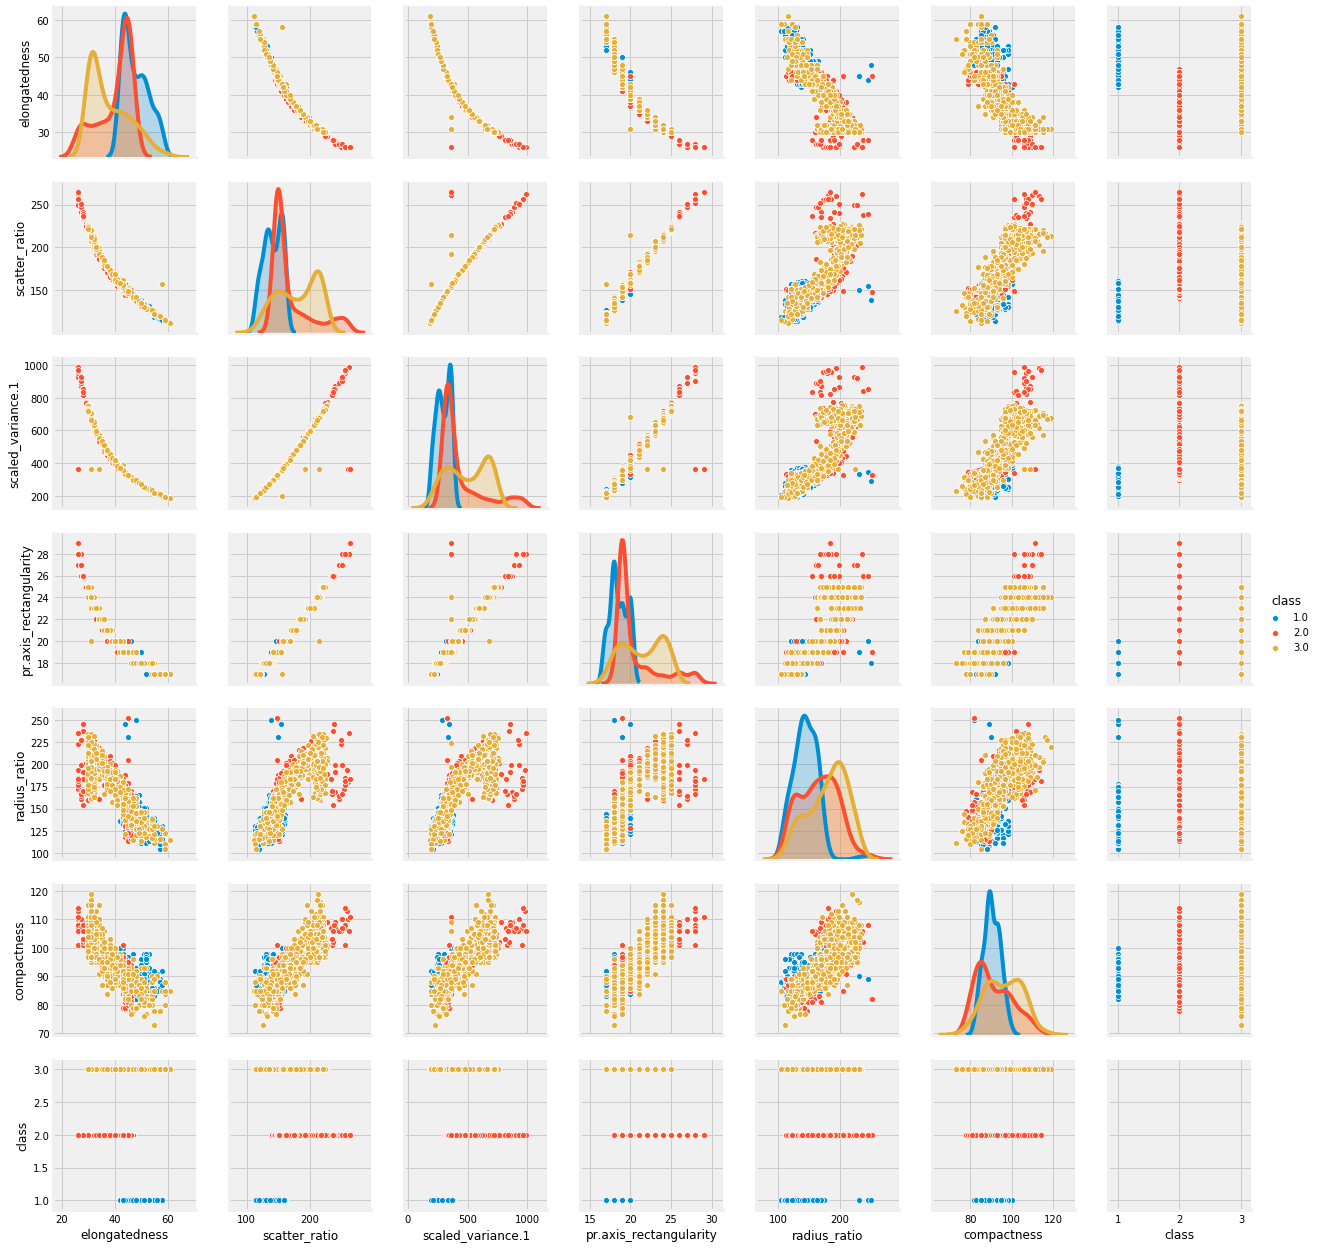

In [30]:
print('Indeed highly correlated variables', '--'*30)
sns.pairplot(vehicle_im[['elongatedness', 'scatter_ratio', 'scaled_variance.1', 
             'pr.axis_rectangularity', 'radius_ratio', 'compactness', 'class']], hue = 'class')

In [31]:
vehicle_im.shape

(846, 13)

In [32]:
# Creating separate variables for features and target
features = vehicle_im.iloc[:, 0:12]; features_list = list(features.columns)
target = vehicle_im['class']

features.shape, target.shape

((846, 12), (846,))

### PCA

Steps performed:
<ul>
    <li>let's first split the data into train and test set before scaling and performing rest of the PCA steps.</li>
    <li>Creating a covariance matrix for identifying Principal components </li>
    <li>Identify eigen values and eigen vector </li>
    <li>Finding variance and cumulative variance by each eigen vector</li>
    <li>Use PCA from sklearn and find Principal Components. Transform data to components formed.</li>
</ul>

In [35]:
# Splitting the data into training and test set in the ratio of 85:25 respectively
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, 
                                                    random_state = random_state, shuffle = False)

In [36]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
y_train = y_train.values
y_test = y_test.values

display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(634, 12)

(634,)

(212, 12)

(212,)

In [37]:
# Covariance matrix
cov_matrix = np.cov(X_train.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00157978  0.6927466   0.72862246  0.19898718  0.49505746  0.81440645
  -0.78865303  0.81671979  0.81013144 -0.23968157  0.19300214  0.15222827]
 [ 0.6927466   1.00157978  0.64967972  0.21559846  0.56170726  0.8488418
  -0.82596821  0.84312815  0.83012816  0.06020995  0.11617679 -0.01374727]
 [ 0.72862246  0.64967972  1.00157978  0.6458051   0.46182824  0.77614113
  -0.82845233  0.75248537  0.76394977 -0.38576407  0.03171845  0.19228994]
 [ 0.19898718  0.21559846  0.6458051   1.00157978  0.13974833  0.19695357
  -0.29410931  0.16953522  0.1946448  -0.3107984  -0.05839069 -0.02595801]
 [ 0.49505746  0.56170726  0.46182824  0.13974833  1.00157978  0.49596454
  -0.50931992  0.49250771  0.46287865 -0.32635155  0.08945289  0.15872201]
 [ 0.81440645  0.8488418   0.77614113  0.19695357  0.49596454  1.00157978
  -0.97322484  0.99049017  0.98555786  0.00793151  0.04716969  0.2125568 ]
 [-0.78865303 -0.82596821 -0.82845233 -0.29410931 -0.50931992 -0.97322484
   1.001579

In [38]:
# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-3.39450715e-01  2.36357770e-02 -1.63175268e-01 -6.33209676e-02
  -1.45937709e-02  3.85496746e-01  8.02007929e-01 -2.06839187e-01
   9.52114113e-03 -2.79550123e-02  1.33738935e-01 -8.51456120e-04]
 [-3.39576130e-01 -1.76359038e-01  3.31498572e-02 -1.88619678e-01
   1.58754055e-01 -2.27806785e-01 -2.50134455e-01 -8.17630172e-01
   2.30219364e-02 -3.24498995e-02  2.09070144e-02 -8.18780263e-02]
 [-3.39786015e-01  3.05768414e-01  1.68414061e-01 -4.04368461e-02
  -1.67741829e-01  3.73521106e-02 -7.12117053e-02  1.47234052e-01
   1.40364519e-02 -2.04231985e-02 -2.11786378e-01 -8.11975143e-01]
 [-1.32048433e-01  5.17895579e-01  4.65277587e-01 -2.26573804e-01
  -3.15478527e-01 -4.09971025e-01  1.87407805e-01 -2.88899782e-02
  -1.92555573e-02  3.03940544e-02  2.26065837e-02  3.75717404e-01]
 [-2.36731239e-01  1.72203564e-01 -2.89579241e-01  1.66499147e-02
   6.73394380e-01 -5.20849315e-01  1.74163583e-01  2.70023726e-01
  -4.90218338e-04 -2.67872955e-02 -3.44032638e-02 -1.6

In [39]:
# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 54.37087735  67.26948354  76.54136817  85.49773096  91.78218978
  95.9440383   97.65085431  98.9204619   99.43293559  99.78135812
  99.95111763 100.        ]


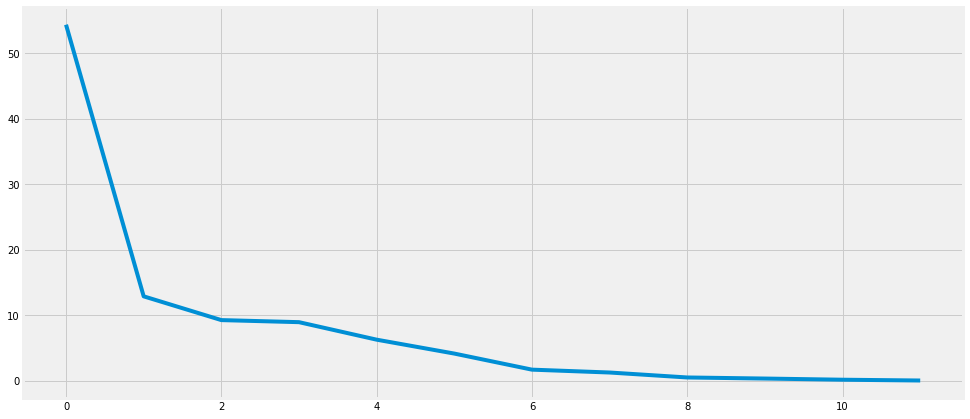

In [40]:
plt.figure(figsize = (15 , 7.2))
plt.plot(var_exp)

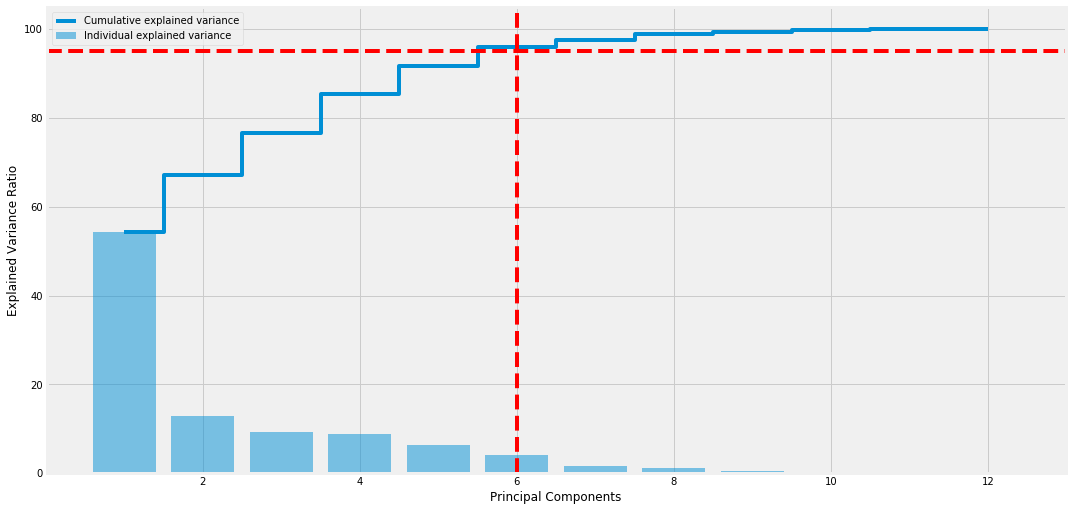

In [41]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = 95, color = 'r', linestyle = '--')
plt.axvline(x = 6, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

####  Observation PCA
Visually we can observe that their is steep drop in variance explained with increase in number of PC's.
We will proceed with 6 components here which covers more than 95% of variance.

In [42]:
# Reducing the dimensions from 12 to 6
pca = PCA(n_components = 6, random_state = random_state)
pca.fit(X_train)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)
display(X_train_reduced.shape, X_test_reduced.shape)

(634, 6)

(212, 6)

In [43]:
pca.components_

array([[ 0.34009463,  0.33794945,  0.33503446,  0.13041569,  0.23652898,
         0.38048316, -0.38018014,  0.37579804,  0.3752845 , -0.05863032,
         0.05802983,  0.08216775],
       [-0.01708559,  0.18133851, -0.32574657, -0.54502345, -0.19833762,
         0.15551679, -0.04657311,  0.18064402,  0.13444857,  0.64541435,
         0.165809  ,  0.05665432],
       [ 0.06575121,  0.17648847, -0.03327224, -0.01308773,  0.12490053,
        -0.05935091,  0.04297934, -0.06143859, -0.06308507, -0.09867145,
         0.66276782, -0.6967989 ],
       [ 0.2112849 , -0.13502957, -0.1346522 , -0.37483765,  0.31520721,
        -0.0682641 ,  0.10682439, -0.04298389, -0.0485113 , -0.36467931,
         0.45724618,  0.56284827],
       [-0.05721052, -0.13484345,  0.19649251,  0.4550835 , -0.54315451,
         0.00282427, -0.04349429, -0.02006966,  0.02745604,  0.1809912 ,
         0.54106651,  0.33052979],
       [ 0.37871695, -0.29415461,  0.06660237, -0.36394537, -0.61434687,
         0.09278887, -

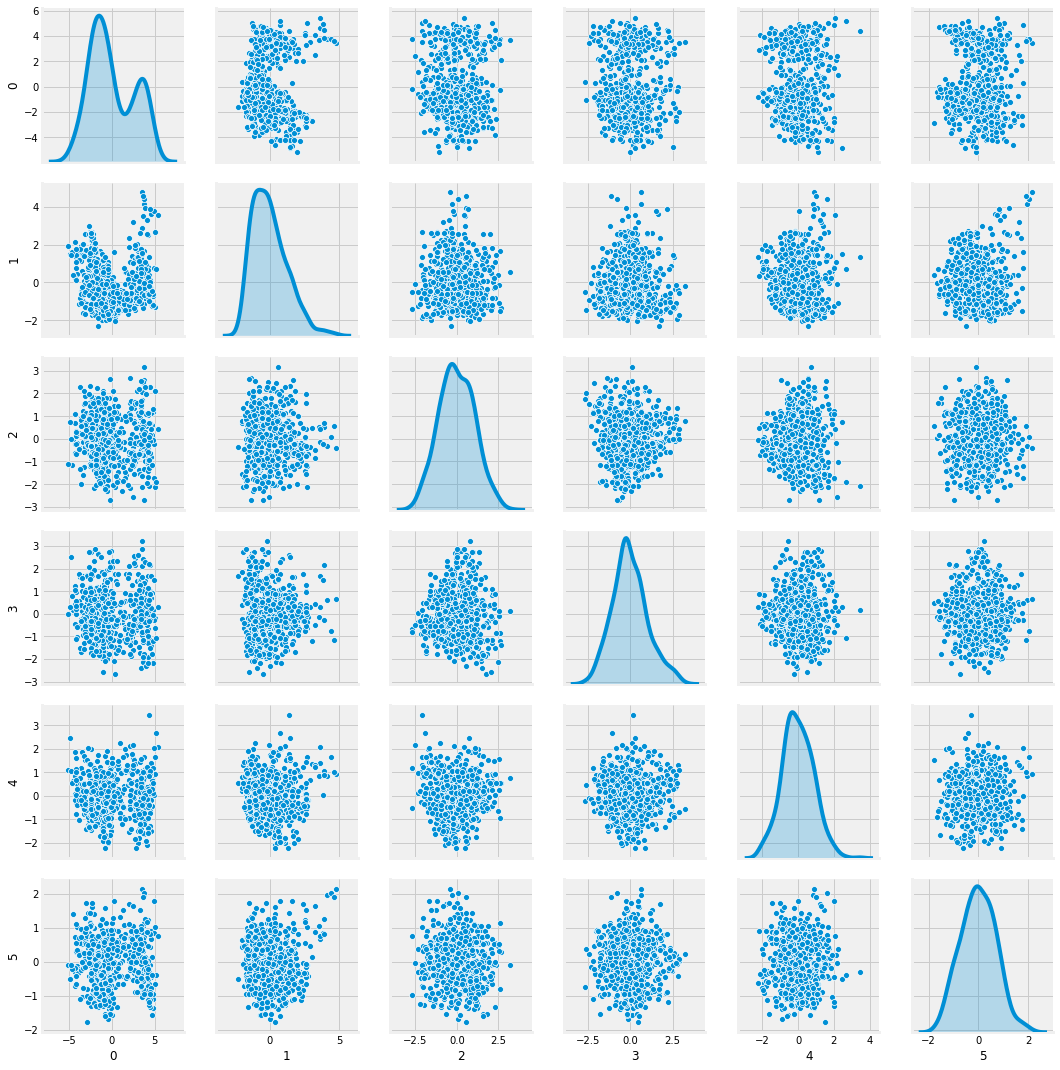

In [44]:
# Pairplot after dimension reduction
sns.pairplot(pd.DataFrame(X_train_reduced), diag_kind = 'kde')

In [45]:
# Creating a dimension reduced with features and target
df_train = pd.DataFrame(X_train_reduced).join(pd.DataFrame(y_train, columns = ['class']), how = 'left', sort = False)
df_test = pd.DataFrame(X_test_reduced).join(pd.DataFrame(y_test, columns = ['class']), how = 'left', sort = False)
df_train.shape, df_test.shape

((634, 7), (212, 7))

#### Dimensionality Reduction

After dimensionality reduction using PCA our attributes have become independent with no correlation among themselves

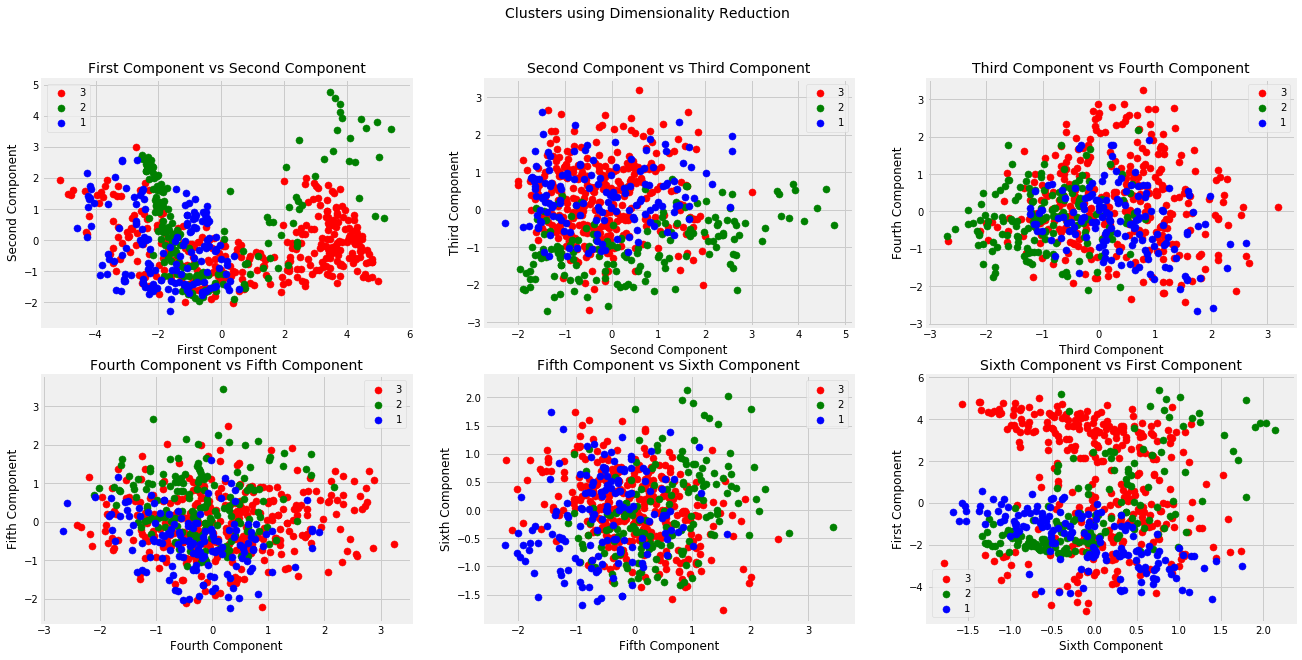

In [46]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (20, 10))
f.suptitle('Clusters using Dimensionality Reduction', fontsize = 14)

pca_plots(df_train, 0, 1, 'First Component', 'Second Component', ax1)
pca_plots(df_train, 1, 2, 'Second Component', 'Third Component', ax2)
pca_plots(df_train, 2, 3, 'Third Component', 'Fourth Component', ax3)
pca_plots(df_train, 3, 4, 'Fourth Component', 'Fifth Component', ax4)
pca_plots(df_train, 4, 5, 'Fifth Component', 'Sixth Component', ax5)
pca_plots(df_train, 5, 0, 'Sixth Component', 'First Component', ax6)

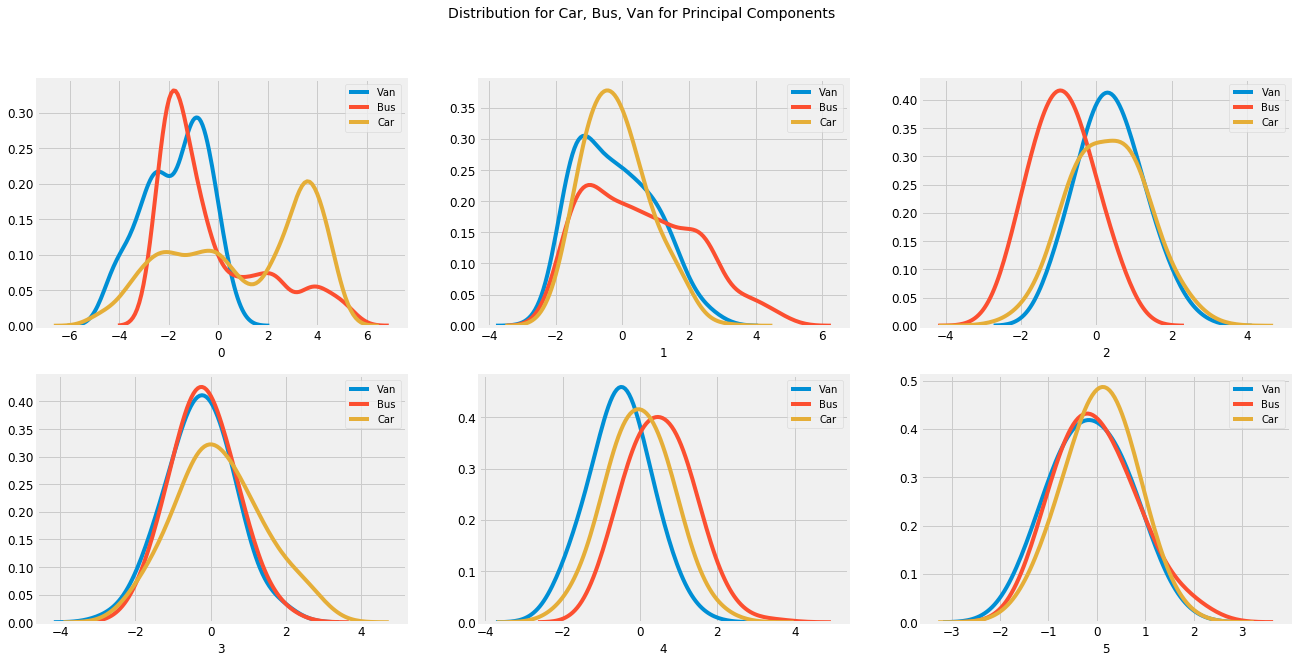

In [47]:


features = [f for f in df_train.columns if f not in ['class']]

i = 0
t1 = df_train[df_train['class'] == 1]
t2 = df_train[df_train['class'] == 2]
t3 = df_train[df_train['class'] == 3]

fig, ax = plt.subplots(2, 3, figsize = (20, 10))
fig.suptitle('Distribution for Car, Bus, Van for Principal Components', fontsize = 14)

for feature in features:
    i += 1
    plt.subplot(2, 3, i)
    sns.kdeplot(t1[feature], bw = 0.5, label = 'Van')
    sns.kdeplot(t2[feature], bw = 0.5, label = 'Bus')
    sns.kdeplot(t3[feature], bw = 0.5, label = 'Car')
    plt.xlabel(feature, fontsize = 12)
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()



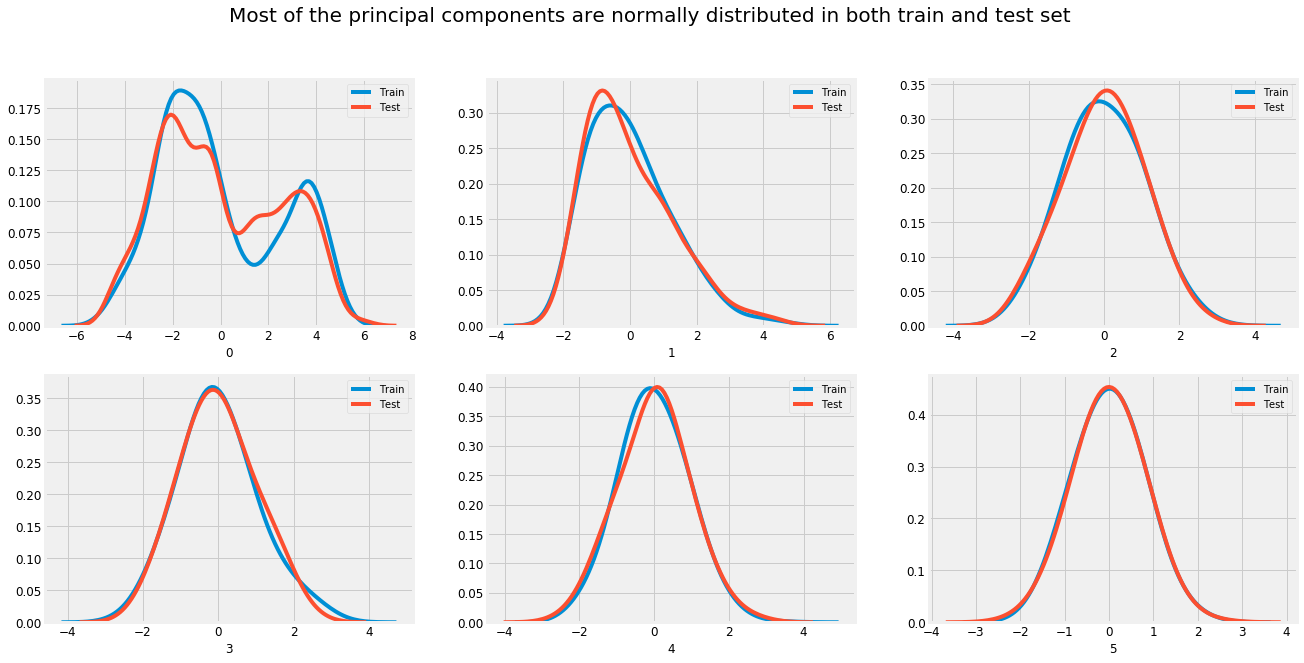

In [48]:
features = [f for f in df_train.columns if f not in ['class']]

i = 0
ttr = df_train.drop(['class'], axis = 1)
tte = df_test.drop(['class'], axis = 1)

fig, ax = plt.subplots(2, 3, figsize = (20, 10))
fig.suptitle('Most of the principal components are normally distributed in both train and test set', fontsize = 20)

for feature in features:
    i += 1
    plt.subplot(2, 3, i)
    sns.kdeplot(ttr[feature], bw = 0.5, label = 'Train')
    sns.kdeplot(tte[feature], bw = 0.5, label = 'Test')
    plt.xlabel(feature, fontsize = 12)
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show();

### Modelling

Use grid search for SVC (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyper parameters and do cross validation to find the accuracy.

LR: 0.782003 (0.051113)
KNN: 0.845923 (0.036586)
NB: 0.766352 (0.073005)
SVC: 0.889301 (0.024236)
CART: 0.814885 (0.040535)
RF: 0.863957 (0.031966)


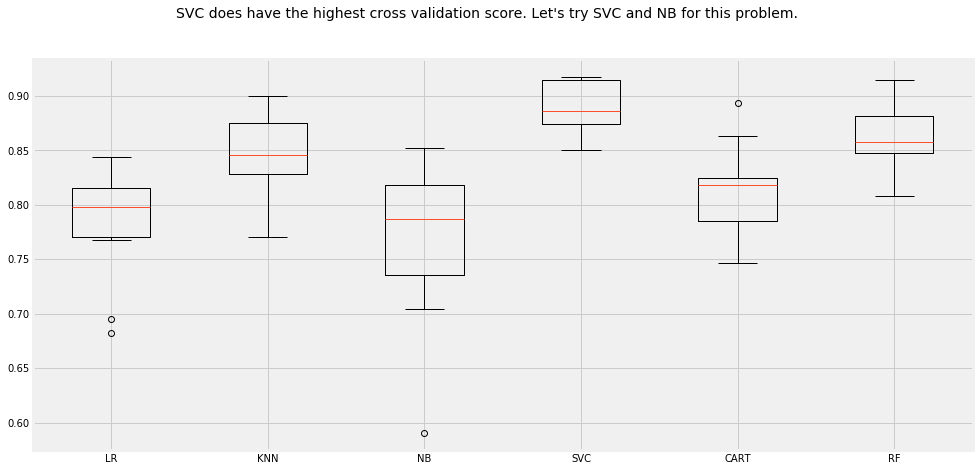

In [49]:
# Compare different models on the principal components
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'f1_macro'
for name, model in models:
    skf = StratifiedKFold(n_splits = 10, random_state = random_state)
    cv_results = cross_val_score(model, X_train_reduced, y_train, cv = skf, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure(figsize = (15, 7.2))
fig.suptitle(f'SVC does have the highest cross validation score. Let\'s try SVC and NB for this problem.', fontsize = 14)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [50]:
# Naive Bayes Model -- Principal Components
NB = GaussianNB()
NB.fit(X_train_reduced, y_train)

print('Naive Bayes Classifier Scores\n\n')
print('NB accuracy for train set: {0:.3f}'.format(NB.score(X_train_reduced, y_train)))
print('NB accuracy for test set: {0:.3f}'.format(NB.score(X_test_reduced, y_test)))

y_true, y_pred = y_test, NB.predict(X_test_reduced)

# Cross Validation Score
skf = StratifiedKFold(n_splits = 10, random_state = random_state)
nb_score = cross_val_score(NB, X_train_reduced, y_train, cv = skf, scoring = scoring)
print('NB cross validation training score: ', round(nb_score.mean(), 3).astype(str))

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

Naive Bayes Classifier Scores


NB accuracy for train set: 0.798
NB accuracy for test set: 0.675
NB cross validation training score:  0.766

Accuracy Score:
 0.675

              precision    recall  f1-score   support

         1.0       0.58      0.67      0.62        49
         2.0       0.60      0.53      0.56        53
         3.0       0.76      0.75      0.75       110

    accuracy                           0.67       212
   macro avg       0.64      0.65      0.64       212
weighted avg       0.68      0.67      0.67       212


Confusion Matrix:
 [[33  3 13]
 [12 28 13]
 [12 16 82]]


In [51]:
# SVC with hyperparameter tuning -- Principal Components
svc = SVC(random_state = random_state)

params = {'C': [0.01, 0.05, 0.5, 1], 'kernel': ['linear', 'rbf']}

skf = StratifiedKFold(n_splits = 10, random_state = random_state)
grid_svc = GridSearchCV(svc, param_grid = params, n_jobs = -1, cv = skf)

grid_svc.fit(X_train_reduced, y_train)

print('SVC Scores with Hyperparameter Tuning\n\n')
print('Best Hyper Parameters are: ', grid_svc.best_params_)
print('Best Score is: ', grid_svc.best_score_.round(3))

print('SVC accuracy for train set: {0:.3f}'.format(grid_svc.score(X_train_reduced, y_train)))
print('SVC accuracy for test set: {0:.3f}'.format(grid_svc.score(X_test_reduced, y_test)))

y_true, y_pred = y_test, grid_svc.predict(X_test_reduced)

# Cross Validation Score
grid_svc_score = cross_val_score(grid_svc, X_train_reduced, y_train, cv = skf, scoring = scoring)
print('SVC cross validation training score: ', round(grid_svc_score.mean(), 3).astype(str))

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

SVC Scores with Hyperparameter Tuning


Best Hyper Parameters are:  {'C': 1, 'kernel': 'rbf'}
Best Score is:  0.896
SVC accuracy for train set: 0.918
SVC accuracy for test set: 0.778
SVC cross validation training score:  0.889

Accuracy Score:
 0.778

              precision    recall  f1-score   support

         1.0       0.65      0.73      0.69        49
         2.0       0.77      0.77      0.77        53
         3.0       0.85      0.80      0.82       110

    accuracy                           0.78       212
   macro avg       0.76      0.77      0.76       212
weighted avg       0.78      0.78      0.78       212


Confusion Matrix:
 [[36  2 11]
 [ 7 41  5]
 [12 10 88]]


In [52]:


# SVC with hyperparameter tuning -- Original Features
svc = SVC(random_state = random_state)

params = {'C': [0.01, 0.05, 0.5, 1], 'kernel': ['linear', 'rbf']}

skf = StratifiedKFold(n_splits = 10)
grid_svc_f = GridSearchCV(svc, param_grid = params, n_jobs = -1, cv = skf)

grid_svc_f.fit(X_train, y_train)

print('SVC Scores with Hyperparameter Tuning\n\n')
print('Best Hyper Parameters are: ', grid_svc_f.best_params_)
print('Best Score is: ', grid_svc_f.best_score_.round(3))

print('SVC accuracy for train set: {0:.3f}'.format(grid_svc_f.score(X_train, y_train)))
print('SVC accuracy for test set: {0:.3f}'.format(grid_svc_f.score(X_test, y_test)))

y_true, y_pred = y_test, grid_svc_f.predict(X_test)

# Cross Validation Score
grid_svc_f_score = cross_val_score(grid_svc_f, X_train, y_train, cv = skf, scoring = scoring)
print('SVC cross validation training score: ', round(grid_svc_f_score.mean(), 3).astype(str))

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)



SVC Scores with Hyperparameter Tuning


Best Hyper Parameters are:  {'C': 1, 'kernel': 'rbf'}
Best Score is:  0.924
SVC accuracy for train set: 0.950
SVC accuracy for test set: 0.929
SVC cross validation training score:  0.921

Accuracy Score:
 0.929

              precision    recall  f1-score   support

         1.0       0.92      0.90      0.91        49
         2.0       0.91      0.96      0.94        53
         3.0       0.94      0.93      0.94       110

    accuracy                           0.93       212
   macro avg       0.92      0.93      0.93       212
weighted avg       0.93      0.93      0.93       212


Confusion Matrix:
 [[ 44   1   4]
 [  0  51   2]
 [  4   4 102]]


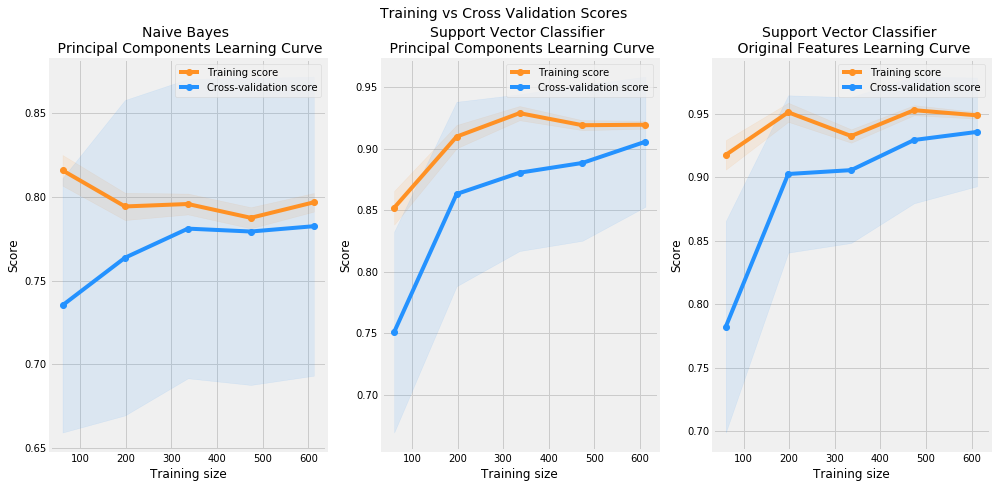

In [53]:
# Plot training vs cross validation scores
cv = StratifiedKFold(n_splits = 30, random_state = random_state)

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 7.2))
f.suptitle('Training vs Cross Validation Scores', fontsize = 14)

plot_learning_curve(NB, X_train_reduced, y_train, cv = cv, n_jobs = 1, ax = ax1,
                    name = 'Naive Bayes \n Principal Components Learning Curve')

plot_learning_curve(grid_svc, X_train_reduced, y_train, cv = cv, n_jobs = 1, ax = ax2, 
                    name = 'Support Vector Classifier \n Principal Components Learning Curve')

plot_learning_curve(grid_svc_f, X_train, y_train, cv = cv, n_jobs = 1, ax = ax3,
                    name = 'Support Vector Classifier \n Original Features Learning Curve')

## Conclusion

We used correlation matrix and checked the relation of each feature with the class column to reduce the number of features in the dataset to 12 from 18.

PCA being a statistical technique to reduce the dimensionality of the data by the selecting the most important features that captures maximum information about the dataset, does the task here. Here we've reduced the dimension from 12 to 6 and selected those which explained 95% variance. Doing that it removes the correlated features as well, which we saw in the scatterplot before and after PCA.

However, some of the limitations which are clearly seen in this use case are: after implementing PCA on the dataset, we saw features getting converted into principal components. Principal components are the linear combination of original features. This makes the features less interpretable. Additionally, we know that one of limitation of PCA is it assumes linearity i.e. principal components are a linear combinations of the original features, which if not true will not give a sensible results..

We then applied Naive Bayes and Support Vector Classifier on the reduced features (dimensions) and got an accuracy of 67.5% and 78.3% respectively and precision (macro) score of 64% and 76% respectively. Recall (macro) score for the same was 65% and 77% respectively. We then also applied SVC on the 12 actual features (with interpretability) and saw an accuracy score of 92.9%, precision (macro) score of 92% and recall (macro) score of 93%, which is a way better score then SVC when applied on principal components.

Shape of dataset we were dealing with was 846 rows and 12 features + 1 class column. Effect of PCA can be more useful in large datasets with more features.

Based on learning curve, we can conclude that for Naive Bayes with principal components, both training and validation scores are volatile, however the validation score almost flattens beyond a training size of ~330. For SVC with principal components and original features, both training and validation scores increases with the increase in size of the dataset, which would mean the scores can be further increases with more training samples. Howevver, the gap between training and validation score for SVC with principal component is higher than then the others.